## IDs:
ID 1: 204502926 <br>
ID 2: 039065313

## Imports:

In [1]:
import numpy as np
import pandas as pd
# %matplotlib inline
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
from numpy.linalg import solve

np.random.seed(0)

### Question 1: Data exploration (15 points)

#### Answer:

In [97]:
def make_histogram(dataset, attribute, bins=25, bar_color='#3498db', edge_color='#2980b9', title='Title', xlab='X', ylab='Y', sort_index=False): 
    fig, ax = plt.subplots(figsize=(9, 7))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(title, fontsize=24, pad=5, bbox={'facecolor':'k', 'pad':5}, color='w')
    ax.set_xlabel(xlab, fontsize=16, labelpad=10)
    ax.set_ylabel(ylab, fontsize=16, labelpad=20)
    plt.xticks(rotation=45)
    plt.hist(dataset[attribute], bins=50, color=bar_color, ec=edge_color, linewidth=2)

   user_id  item_id  rating  timestamp
0      196      242       3  881250949
1      186      302       3  891717742
2       22      377       1  878887116
3      244       51       2  880606923
4      166      346       1  886397596
Sparsity: 0.9369533063577546



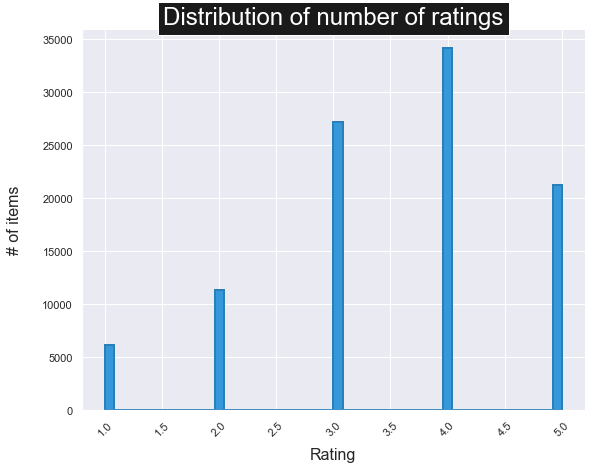

In [98]:
# Calculate the dataset sparsity, distribution of number of ratings as well as the average rating value per user\item. 
# Include additional exploration you find relevant to questions 2 and 3.
# Discuss your insights and possible challenges related to the prediction task described in question 2.


# Remember that sparsity is calculated by the number of cells in a matrix that contain a rating divided by the total number of values that matrix could hold given the number of users and items (movies). 
# In other words, dividing the number of ratings present in the matrix by the product of users and movies in the matrix and subtracting that from 1 will give us the sparsity or the percentage of the ratings matrix that is empty.

file_path = 'ml-100k/u.data' # grouplens.org/datasets/movielens/100k

names = ['user_id', 'item_id', 'rating', 'timestamp']
data = pd.read_csv(file_path, sep='\t', names=names)

print(data.head())

all_users_ids = data.user_id.unique()
all_items_ids = data.item_id.unique()
ratings_count = data.shape[0] # 100,000
users_count = len(all_users_ids)
items_count = len(all_items_ids)
sparsity = 1 - (ratings_count / (users_count * items_count))
print(f'Sparsity: {sparsity}')
print()


make_histogram(data, 'rating', title='Distribution of number of ratings', xlab='Rating', ylab='# of items')

We can see that **'4'** is the dominant rating (34,174 ratings)<br>
The average rating is: $\frac{\sum_{i=1}^n(i * y(i))}{|S|}$, where i is a rating value (1-5), y(i) is the amount of ratings per user/item, and |S| is the size of the dataset (100K).<br>
We can also see that the users are more prone to give a perfect rating ('5') rather than < '3'.

In [99]:
average = sum(data['rating']) / len(data['rating'])
print(f'The average rating is {average}')

The average rating is 3.52986



### Question 2: Matrix factorization model implementation and evaluation (60 points)

#### Answer:

In [5]:
def create_rating_matrix_from_raw_data(df):
    ratings = np.zeros((all_users_ids.shape[0], all_items_ids.shape[0]))

    for row in df.itertuples():
        ratings[row[1]-1][row[2]-1] = row[3]  
        
    return ratings

In [6]:
ratings = create_rating_matrix_from_raw_data(data)
# ratings.shape

In [7]:
def get_5_folds(folds_dir='./ml-100k/'):
    
    
    
    
    
#     change to 5!!!!!!!






    number_of_folds = 2
    header = ['user_id', 'item_id', 'rating', 'timestamp']
    folds = []
    
    for i in range(number_of_folds):     
        print(f'{folds_dir}u{i+1}.base')
        
        df_train = pd.read_csv(f'{folds_dir}u{i+1}.base', sep='\t', names=header)
        df_test = pd.read_csv(f'{folds_dir}u{i+1}.test', sep='\t', names=header)   
        
        rating_train = create_rating_matrix_from_raw_data(df_train)
        rating_test  = create_rating_matrix_from_raw_data(df_test)        
           
        folds.append((rating_train, rating_test))
        
    return folds


folds = get_5_folds()

for fold in folds:
    print(fold[0].shape, fold[1].shape)

./ml-100k/u1.base
./ml-100k/u2.base
(943, 1682) (943, 1682)
(943, 1682) (943, 1682)


In [8]:
from sklearn.metrics import mean_squared_error

def get_mse(pred, actual):
    # Ignore nonzero terms
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    
    return mean_squared_error(pred, actual)

In [9]:
class ExplicitMFSGD():
    def __init__(self, 
                 ratings,
                 k_factors = 40,
                 item_fact_reg = 0.0, 
                 user_fact_reg = 0.0,
                 item_bias_reg = 0.0,
                 user_bias_reg = 0.0,
                 verbose = False):
        """
        Train a matrix factorization model to predict empty entries in a matrix. 
        The terminology assumes a ratings matrix which is ~ user x item.
        
        (To avoid overfitting we use regularization)

        Params
        ======
        ratings: (ndarray)
            User x Item matrix with corresponding ratings
        
        k_factors: (int)
            Number of latent factors to use in matrix factorization model
        
        item_fact_reg: (float)
            Regularization term for item latent factors
            
        user_fact_reg: (float)
            Regularization term for user latent factors
            
        item_bias_reg: (float)
            Regularization term for item biases
        
        user_bias_reg: (float)
            Regularization term for user biases
        
        verbose: (bool)
            Whether or not to printout training progress
        """
        
        self.ratings = ratings
        self.users_count = users_count
        self.items_count = items_count
        self.k_factors = k_factors
        self.item_fact_reg = item_fact_reg
        self.user_fact_reg = user_fact_reg
        self.item_bias_reg = item_bias_reg
        self.user_bias_reg = user_bias_reg
        
        self.sample_row, self.sample_col = self.ratings.nonzero()
        self.n_samples = len(self.sample_row)
        self._v = verbose
        self.curr_iter = 1
        self.user_vecs, self.item_vecs = None, None
        
    def calculate_learning_curve(self, iter_array, test, learning_rate):
        iter_array.sort()
        self.init_for_train(learning_rate)
        training_mse, test_mse = [], []
        
        for n_iter in iter_array:            
            self.print_verbose(f'k={self.k_factors}, alpha={learning_rate}, '\
                              f'iterations={n_iter}, item_fact_reg={self.item_fact_reg}, '\
                              f'user_fact_reg={self.user_fact_reg}, item_bias_reg={self.item_bias_reg}, '\
                              f'user_bias_reg={self.user_bias_reg}')
            self.train(n_iter)
            predictions = self.get_prediction_matrix()
            self.evaluate(predictions, training_mse, test_mse, test)
            
        print('============================================')
        
        return training_mse, test_mse
    
    
    def init_for_train(self, learning_rate=0.1):        
        # initialize latent vectors
        # Approximate rating matrix by product of lower rank matrix
        self.user_vecs = np.random.normal(scale=1./self.k_factors, size=(self.users_count, self.k_factors))
        self.item_vecs = np.random.normal(scale=1./self.k_factors, size=(self.items_count, self.k_factors))
        
        self.learning_rate = learning_rate
        self.user_bias = np.zeros(self.users_count)
        self.item_bias = np.zeros(self.items_count)
        self.global_bias = np.mean(self.ratings[np.where(self.ratings != 0)])

    def train(self, n_iter):
        """ 
        Train model for n_iter iterations. 
        Can be called multiple times for further training.
        """
        while self.curr_iter <= n_iter:
            if self.curr_iter % 10 == 0 and n_iter > 10 and self._v:
                print(f'\tStill running...')
                print(f'\tCurrent iteration: {self.curr_iter}')
                
            self.training_indices = np.arange(self.n_samples)
            np.random.shuffle(self.training_indices)
            self.perform_sgd()
            self.curr_iter += 1
            
    def predict(self, user, item):
        """
        Single user and item prediction
        """
        biases = self.global_bias + self.user_bias[user] + self.item_bias[item]
        prediction_value = biases + self.user_vecs[user, :].dot(self.item_vecs[item, :].T)
        
        return prediction_value
    
    def perform_sgd(self):
        for idx in self.training_indices:
            user = self.sample_row[idx]
            item = self.sample_col[idx]
            prediction = self.predict(user, item)
            actual_rating = self.ratings[user, item] # get actual rating from the dataset's ratings array 
            error = actual_rating - prediction
            
            # Update biases
            self.user_bias[user] += self.learning_rate * (error - self.user_bias_reg * self.user_bias[user])
            self.item_bias[item] += self.learning_rate * (error - self.item_bias_reg * self.item_bias[item])
            
            # Update latent factors
            self.user_vecs[user, :] += self.learning_rate * (error * self.item_vecs[item, :] - self.user_fact_reg * self.user_vecs[user,:])
            self.item_vecs[item, :] += self.learning_rate * (error * self.user_vecs[user, :] - self.item_fact_reg * self.item_vecs[item,:])
    
    def get_prediction_matrix(self):
        """
        Predict ratings for every user and item
        """
        predictions = np.zeros((self.user_vecs.shape[0], 
                                self.item_vecs.shape[0]))
        
        for user in range(self.user_vecs.shape[0]):
            for item in range(self.item_vecs.shape[0]):
                predictions[user, item] = self.predict(user, item)
                
        return predictions
    
    def evaluate(self, predictions, training_mse, test_mse, test):
        training_mse.append(get_mse(predictions, self.ratings))
        test_mse.append(get_mse(predictions, test))

        self.print_verbose(f'Training MSE = {training_mse[-1]}')
        self.print_verbose(f'Test MSE = {test_mse[-1]}')

    def print_verbose(self, msg):
        if self._v:
            print(msg)

In [10]:
class ExplicitMFALS:
    def __init__(self,
                 ratings,
                 k_factors=40,
                 item_reg=0.0,
                 user_reg=0.0,
                 verbose=False):
        self.ratings = ratings
        self.users_count = users_count
        self.items_count = items_count        
        self.k_factors = k_factors
        self.item_reg = item_reg
        self.user_reg = user_reg
        self._v = verbose
        self.curr_iter = 1

    def calculate_learning_curve(self, iter_array, test):
        iter_array.sort()
        self.init_for_train()
        training_mse, test_mse = [], []
        
        for n_iter in iter_array:            
            self.print_verbose(f'k={self.k_factors}, '\
                               f'iterations={n_iter}, '\
                               f'item_reg={self.item_reg}, '\
                               f'user_reg={self.user_reg}')
            self.train(n_iter)
            predictions = self.predict_all()
            self.evaluate(predictions, training_mse, test_mse, test)  
        print('============================================')
        return training_mse, test_mse
    
    def als_step_user(self):
        YTY = self.item_vecs.T.dot(self.item_vecs)
        lambdaI = np.eye(YTY.shape[0]) * self.user_reg

        for u in range(self.user_vecs.shape[0]):
            self.user_vecs[u, :] = solve((YTY + lambdaI), self.ratings[u, :].dot(self.item_vecs))

    def als_step_item(self):
        XTX = self.user_vecs.T.dot(self.user_vecs)
        lambdaI = np.eye(XTX.shape[0]) * self.item_reg

        for i in range(self.item_vecs.shape[0]):
            self.item_vecs[i, :] = solve((XTX + lambdaI), self.ratings[:, i].T.dot(self.user_vecs))

    def init_for_train(self):
        # initialize latent vectors
        self.user_vecs = np.random.normal(scale=1. / self.k_factors,
                                          size=(self.users_count, self.k_factors))
        self.item_vecs = np.random.normal(scale=1. / self.k_factors,
                                          size=(self.items_count, self.k_factors))
        print(f'user_vecs: {self.user_vecs.shape}, item_vecs: {self.item_vecs.shape}')

    def train(self, n_iter):
        """ 
        Train model for n_iter iterations. 
        Can be called multiple times for further training.
        """
        while self.curr_iter <= n_iter:
            if self.curr_iter % 10 == 0 and self._v:
                print(f'\tStill running...')
                print(f'\tCurrent iteration: {self.curr_iter}')
                
            self.als_step_user()
            self.als_step_item()
            self.curr_iter += 1
            
    def predict(self, u, i):
        return self.user_vecs[u, :].dot(self.item_vecs[i, :].T)

    def predict_all(self):
        predictions = np.zeros((self.user_vecs.shape[0],
                                self.item_vecs.shape[0]))
        for u in range(self.user_vecs.shape[0]):
            for i in range(self.item_vecs.shape[0]):
                predictions[u, i] = self.predict(u, i)
        return predictions
                       
    def evaluate(self, predictions, training_mse, test_mse, test):
        training_mse.append(get_mse(predictions, self.ratings))
        test_mse.append(get_mse(predictions, test))

        self.print_verbose(f'Training MSE = {training_mse[-1]}')
        self.print_verbose(f'Test MSE = {test_mse[-1]}')
        
    def print_verbose(self, msg):
        if self._v:
            print(msg)        

In [42]:
import copy
from itertools import combinations, combinations_with_replacement, permutations


def permutation_regularization_generator(base_dict):
#     regularization_parameters_values = [0.01, 0.1, 1.0]
    regularization_parameters_values = [0.01]
    regularization_permutations = set()
    number_of_regularization_params = len(base_dict)
    
    for seq in list(combinations_with_replacement(regularization_parameters_values, number_of_regularization_params)):
        for perm_seq in permutations(seq, number_of_regularization_params):
            regularization_permutations.add(perm_seq)

    regularization_parameters_dict_list = []      
    keys = base_dict.keys()
    
    for perm in regularization_permutations:
        curr_values_dict = copy.deepcopy(base_dict)
        
        for idx, key in enumerate(keys):
            curr_values_dict[key] = perm[idx]
        
        regularization_parameters_dict_list.append(curr_values_dict)
        
    return regularization_parameters_dict_list

In [13]:
def generate_list_of_regularization_parameters_values(model_type):
    if model_type == "als":
        base_dict = {'item_reg': 0.0, 'user_reg':0.0}
    else: # model type == "sgd"
        base_dict = {'item_fact_reg': 0.0, 'user_fact_reg': 0.0, 'item_bias_reg': 0.0, 'user_bias_reg':0.0}
        
    return permutation_regularization_generator(base_dict)        

    
def als_model_provider(**params):
    return ExplicitMFALS(**params)


def sgd_model_provider(**params):
    return ExplicitMFSGD(**params)

In [14]:
# CODE EXAMPLE ON HOW I PASSED PARAMS:

def y(a=0, b=1, c=2, d=3):
    print(f'a:{a}, b:{b}, c:{c}, d:{d}')
    
def x(**params):
    y(**params)
    
last_params = {'c': 35, 'd': 45}
x(a=10,b=20,**last_params)   

a:10, b:20, c:35, d:45


In [34]:
def calculate_learning_curve(training_data, test_data, model_provider, model_type="sgd"):
    regularization_parameters_values = generate_list_of_regularization_parameters_values(model_type)    
    perm_count = 1
    params_and_results = []
    
    if model_type == "als":
        hyper_param_learning_iter_num = len(k_options)*len(regularization_parameters_values)
    else: # sgd
        hyper_param_learning_iter_num = len(k_options)*len(learning_rate_options)*len(regularization_parameters_values)
        
    for k in k_options:
        if model_type == "als":
            for regularization_parameters_value in regularization_parameters_values:    
                print(f'iteration {perm_count}/{hyper_param_learning_iter_num}')
                model = model_provider(ratings=training_data, k_factors=k, verbose=True, **regularization_parameters_value)
                training_mse, test_mse = model.calculate_learning_curve(iter_array, test_data)
                curr_run_params_and_results = {"k": k, "training_mse": training_mse, "test_mse": test_mse}
                params_and_results.append({**curr_run_params_and_results, **regularization_parameters_value})    
                perm_count += 1
        else: # sgd
            for learning_rate in learning_rate_options:
                for regularization_parameters_value in regularization_parameters_values:    
                    print(f'iteration {perm_count}/{hyper_param_learning_iter_num} ')
                    model = model_provider(ratings=training_data, k_factors=k, verbose=True, **regularization_parameters_value)
                    training_mse, test_mse = model.calculate_learning_curve(iter_array, test_data, learning_rate)
                    curr_run_params_and_results = {"k": k, "learning_rate": learning_rate, "training_mse": training_mse, "test_mse": test_mse}
                    params_and_results.append({**curr_run_params_and_results, **regularization_parameters_value})    
                    perm_count += 1
                    
    return params_and_results

In [44]:
# OFFICIAL AND FINAL PARAMETERS FOR SUBMISSION
k_options = [5, 10, 20]
learning_rate_options = [0.001, 0.01, 0.1]
iter_array = [1, 5, 10, 25, 50, 100, 200]

# DEMO AND SMALLER PARAMETERS - NOT FOR SUBMISSION
k_options = [5, 10]
learning_rate_options = [0.001, 0.01]
iter_array = [1, 10, 25]

In [45]:
def get_number_of_permutations_string(model_type="sgd"):
    regularization_parameters_values = generate_list_of_regularization_parameters_values(model_type)
    print(f'Total of {len(regularization_parameters_values)} regularization parameters permutations')

    if model_type == "als":
        permutations_string = "(|k's| * |reg's|^2)"
        hyper_param_learning_iter_num = len(k_options)*len(regularization_parameters_values)
    else: # sgd
        permutations_string = "(|k's| * |alphas| * |reg's|^4)"
        hyper_param_learning_iter_num = len(k_options)*len(learning_rate_options)*len(regularization_parameters_values)

    print(f'For each fold - {hyper_param_learning_iter_num} permutations (runs) on the model parameters {permutations_string}')

## Train/Test/Collect ALS 5-folds

In [37]:
als_folds_results = []

get_number_of_permutations_string(model_type="als")
    
for idx, fold in enumerate(folds, start = 0):
    print('============================================')
    print(f'Running on fold {idx}/{len(folds) - 1}')
    training_data, test_data = fold
    params_and_results = calculate_learning_curve(training_data, test_data, model_provider=als_model_provider, model_type="als")
    als_folds_results.append(params_and_results)

Total of 4 regularization parameters permutations
For each fold - 8 permutations (runs) on the model parameters (|k's| * |reg's|^2)
Running on fold 0/1
iteration 1/8
user_vecs: (943, 5), item_vecs: (1682, 5)
k=5, iterations=1, item_reg=0.1, user_reg=0.01
Training MSE = 10.184057963495032
Test MSE = 11.536309404183179
k=5, iterations=10, item_reg=0.1, user_reg=0.01
	Still running...
	Current iteration: 10
Training MSE = 6.738939561594112
Test MSE = 8.670250582552482
k=5, iterations=25, item_reg=0.1, user_reg=0.01
	Still running...
	Current iteration: 20
Training MSE = 6.73647979302336
Test MSE = 8.66877071536693
iteration 2/8
user_vecs: (943, 5), item_vecs: (1682, 5)
k=5, iterations=1, item_reg=0.1, user_reg=0.1
Training MSE = 10.300781351110116
Test MSE = 11.875293551190728
k=5, iterations=10, item_reg=0.1, user_reg=0.1
	Still running...
	Current iteration: 10
Training MSE = 6.746136352343542
Test MSE = 8.677440286550155
k=5, iterations=25, item_reg=0.1, user_reg=0.1
	Still running...


## Train/Test/Collect SGD 5-folds

In [46]:
sgd_folds_results = []

get_number_of_permutations_string(model_type="sgd")

for idx, fold in enumerate(folds, start = 0):
    print('============================================')
    print(f'Running on fold {idx}/{len(folds) - 1}')
    training_data, test_data = fold
    params_and_results = calculate_learning_curve(training_data, test_data, model_provider=sgd_model_provider, model_type="sgd")
    sgd_folds_results.append(params_and_results)

Total of 1 regularization parameters permutations
For each fold - 4 permutations (runs) on the model parameters (|k's| * |alphas| * |reg's|^4)
Running on fold 0/1
iteration 1/4 
k=5, alpha=0.001, iterations=1, item_fact_reg=0.01, user_fact_reg=0.01, item_bias_reg=0.01, user_bias_reg=0.01
Training MSE = 1.1538044214633798
Test MSE = 1.2351177289433846
k=5, alpha=0.001, iterations=10, item_fact_reg=0.01, user_fact_reg=0.01, item_bias_reg=0.01, user_bias_reg=0.01
Training MSE = 0.9245953059707652
Test MSE = 1.003893650018001
k=5, alpha=0.001, iterations=25, item_fact_reg=0.01, user_fact_reg=0.01, item_bias_reg=0.01, user_bias_reg=0.01
	Still running...
	Current iteration: 20
Training MSE = 0.8612932180798897
Test MSE = 0.9512099649119842
iteration 2/4 
k=5, alpha=0.01, iterations=1, item_fact_reg=0.01, user_fact_reg=0.01, item_bias_reg=0.01, user_bias_reg=0.01
Training MSE = 0.9249904336210714
Test MSE = 1.0049803090556433
k=5, alpha=0.01, iterations=10, item_fact_reg=0.01, user_fact_reg=

In [65]:
from collections import defaultdict


def generate_key(dict_item, model_type="sgd"):
    if model_type == "als":
        key = f"k_{dict_item['k']}_ir_{dict_item['item_reg']}_ur_{dict_item['user_reg']}"
    else:
        key = f"k_{dict_item['k']}_lr_{dict_item['learning_rate']}_if_{dict_item['item_fact_reg']}_uf_{dict_item['user_fact_reg']}_ib_{dict_item['item_bias_reg']}_ub_{dict_item['user_bias_reg']}"
    
    return key

def calculate_average(matrix):
    '''
    Take the mean of each column from a given matrix
    '''
    return np.mean(matrix, axis=0)


def get_average_map(given_map):
    for key, value in given_map.items():
        matrix = np.array(value)
        new_value = calculate_average(matrix)
        given_map[key] = new_value
        
    return given_map


def create_error_map(folds_results_list, key_name, model_type="sgd"):
    results_map = defaultdict(list)

    for fold_result in folds_results_list:
        for dict_item in fold_result:
            generated_key = generate_key(dict_item, model_type)
            current_error_list = dict_item[key_name]
            results_map[generated_key].append(current_error_list)
            
    results_map = get_average_map(results_map)
    
    return results_map


def combine_training_and_test_averages_per_model(folds_results_list, averages_training_map, averages_test_map, model_type="sgd"):
    averaged_folds_results = []
    
    for fold_result in folds_results_list[0]:
        dict_copy = fold_result.copy()
        dict_copy['training_mse'] = averages_training_map[generate_key(fold_result, model_type)]
        dict_copy['test_mse'] = averages_test_map[generate_key(fold_result, model_type)]
        averaged_folds_results.append(dict_copy)
            
    return averaged_folds_results

In [66]:
# demo = [
#     [
#     {'k': 10,
#    'learning_rate': 0.001,
#    'training_mse': [0,0,0],
#    'test_mse': [1,1,1],
#    'item_fact_reg': 100.0,
#    'user_fact_reg': 100.0,
#    'item_bias_reg': 100.0,
#    'user_bias_reg': 100.0},
#        {'k': 20,
#    'learning_rate': 0.001,
#    'training_mse': [1,2,3],
#    'test_mse': [0,0,0],
#    'item_fact_reg': 100.0,
#    'user_fact_reg': 100.0,
#    'item_bias_reg': 100.0,
#    'user_bias_reg': 100.0}
#        ],
#     [
#     {'k': 10,
#    'learning_rate': 0.001,
#    'training_mse': [1,1,1],
#    'test_mse': [2,2,2],
#    'item_fact_reg': 100.0,
#    'user_fact_reg': 100.0,
#    'item_bias_reg': 100.0,
#    'user_bias_reg': 100.0},
#        {'k': 20,
#    'learning_rate': 0.001,
#    'training_mse': [5,5,5],
#    'test_mse': [5,5,5],
#    'item_fact_reg': 100.0,
#    'user_fact_reg': 100.0,
#    'item_bias_reg': 100.0,
#    'user_bias_reg': 100.0}
#        ],
# ]

# demo

In [75]:
training_sgd_averages_map = create_error_map(sgd_folds_results, 'training_mse', model_type="sgd")
test_sgd_averages_map = create_error_map(sgd_folds_results, 'test_mse', model_type="sgd")

training_als_averages_map = create_error_map(als_folds_results, 'training_mse', model_type="als")
test_als_averages_map = create_error_map(als_folds_results, 'test_mse', model_type="als")

print(training_sgd_averages_map)
print(test_sgd_averages_map)
print()
print(training_als_averages_map)
print(test_als_averages_map)

defaultdict(<class 'list'>, {'k_5_lr_0.001_if_0.01_uf_0.01_ib_0.01_ub_0.01': array([1.15878202, 0.92724683, 0.8636088 ]), 'k_5_lr_0.01_if_0.01_uf_0.01_ib_0.01_ub_0.01': array([0.9284432 , 0.77518989, 0.6520667 ]), 'k_10_lr_0.001_if_0.01_uf_0.01_ib_0.01_ub_0.01': array([1.1529178 , 0.92520563, 0.86503064]), 'k_10_lr_0.01_if_0.01_uf_0.01_ib_0.01_ub_0.01': array([0.92606102, 0.75625312, 0.54770869])})
defaultdict(<class 'list'>, {'k_5_lr_0.001_if_0.01_uf_0.01_ib_0.01_ub_0.01': array([1.20624705, 0.98589796, 0.9368966 ]), 'k_5_lr_0.01_if_0.01_uf_0.01_ib_0.01_ub_0.01': array([0.98664495, 0.91027633, 0.9112947 ]), 'k_10_lr_0.001_if_0.01_uf_0.01_ib_0.01_ub_0.01': array([1.20042363, 0.98095724, 0.93246976]), 'k_10_lr_0.01_if_0.01_uf_0.01_ib_0.01_ub_0.01': array([0.98147655, 0.89718251, 0.93818814])})

defaultdict(<class 'list'>, {'k_5_ir_0.1_ur_0.01': array([10.25126378,  6.79776003,  6.78977463]), 'k_5_ir_0.1_ur_0.1': array([10.79917332,  6.79761115,  6.78823369]), 'k_5_ir_0.01_ur_0.01': arra

In [82]:
sgd_averages_result = combine_training_and_test_averages_per_model(sgd_folds_results, training_sgd_averages_map, test_sgd_averages_map, model_type="sgd")
print(sgd_averages_result)
print()

als_averages_result = combine_training_and_test_averages_per_model(als_folds_results, training_als_averages_map, test_als_averages_map, model_type="als")
print(als_averages_result)

[{'k': 5, 'learning_rate': 0.001, 'training_mse': array([1.15878202, 0.92724683, 0.8636088 ]), 'test_mse': array([1.20624705, 0.98589796, 0.9368966 ]), 'item_fact_reg': 0.01, 'user_fact_reg': 0.01, 'item_bias_reg': 0.01, 'user_bias_reg': 0.01}, {'k': 5, 'learning_rate': 0.01, 'training_mse': array([0.9284432 , 0.77518989, 0.6520667 ]), 'test_mse': array([0.98664495, 0.91027633, 0.9112947 ]), 'item_fact_reg': 0.01, 'user_fact_reg': 0.01, 'item_bias_reg': 0.01, 'user_bias_reg': 0.01}, {'k': 10, 'learning_rate': 0.001, 'training_mse': array([1.1529178 , 0.92520563, 0.86503064]), 'test_mse': array([1.20042363, 0.98095724, 0.93246976]), 'item_fact_reg': 0.01, 'user_fact_reg': 0.01, 'item_bias_reg': 0.01, 'user_bias_reg': 0.01}, {'k': 10, 'learning_rate': 0.01, 'training_mse': array([0.92606102, 0.75625312, 0.54770869]), 'test_mse': array([0.98147655, 0.89718251, 0.93818814]), 'item_fact_reg': 0.01, 'user_fact_reg': 0.01, 'item_bias_reg': 0.01, 'user_bias_reg': 0.01}]

[{'k': 5, 'training_ms

In [111]:
sns.set()

def plot_learning_curve_list(iter_array, predictions, title, mse_extractor, model_type="als"):
    plt.figure(num=None, figsize=(20, 8), dpi=80, facecolor='w', edgecolor='k')

    for prediction in predictions:
        k = prediction["k"]
        
        if model_type == "als":
            ir, ur = prediction['item_reg'], prediction['user_reg']
            plt.plot(iter_array, mse_extractor(prediction), label=f"{title} k={k}, item_reg={ir}, user_reg={ur}", linewidth=5)
        else:
            learning_rate = prediction["learning_rate"]
            if_reg, uf_reg, ib, ub = prediction['item_fact_reg'], prediction['user_fact_reg'], prediction['item_bias_reg'], prediction['user_bias_reg']
            plt.plot(iter_array, mse_extractor(prediction), label=f"{title} k={k}, α={learning_rate}, if={if_reg}, uf={uf_reg}, if={if_reg}, uf={uf_reg}, ib={ib}, ub={ub}", linewidth=5)
    
    plt.xticks(fontsize=16);
    plt.yticks(fontsize=16);
    plt.xlabel('iterations', fontsize=20);
    plt.ylabel('MSE (averaged)', fontsize=20);
    plt.title(title, fontsize=30, bbox={'facecolor':'k', 'pad':5}, color='w')
    plt.legend(loc='best', fontsize=12);

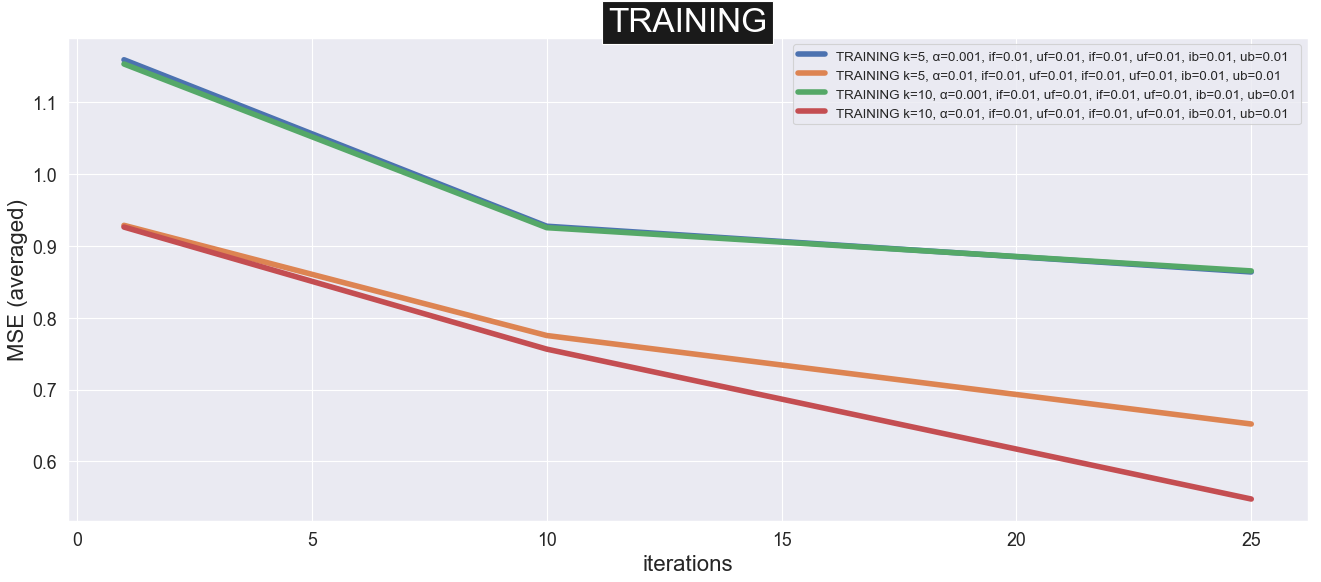

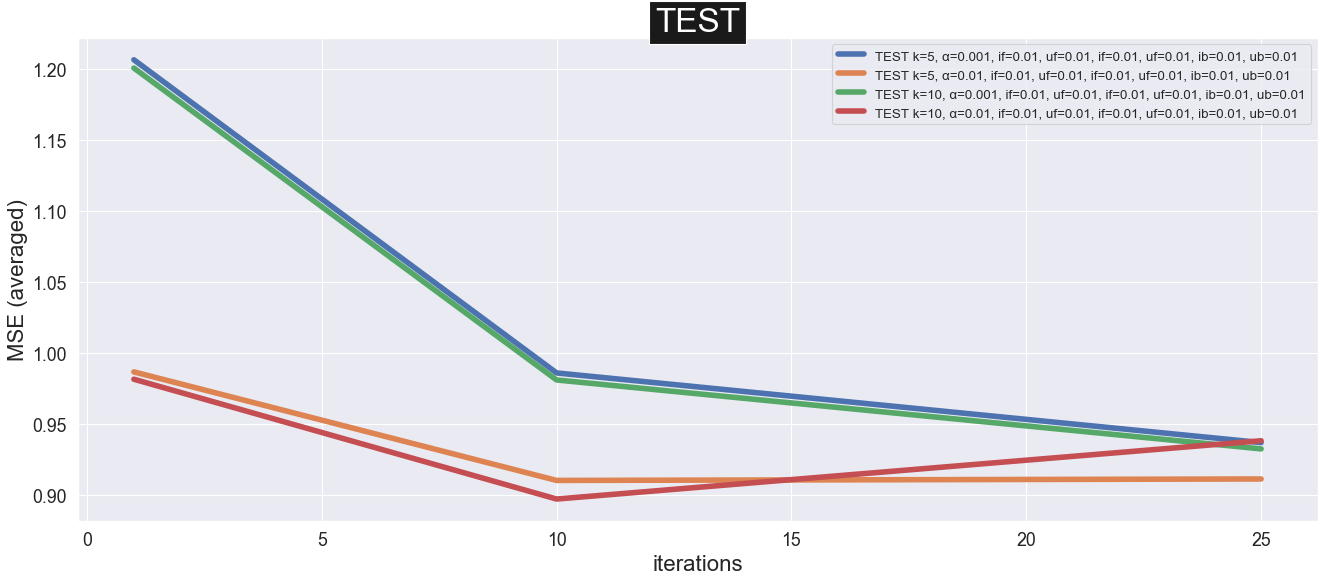

In [112]:
plot_learning_curve_list(iter_array, sgd_averages_result, title='TRAINING', mse_extractor=lambda model: model["training_mse"], model_type="sgd")
plot_learning_curve_list(iter_array, sgd_averages_result, title='TEST', mse_extractor=lambda model: model["test_mse"], model_type="sgd")

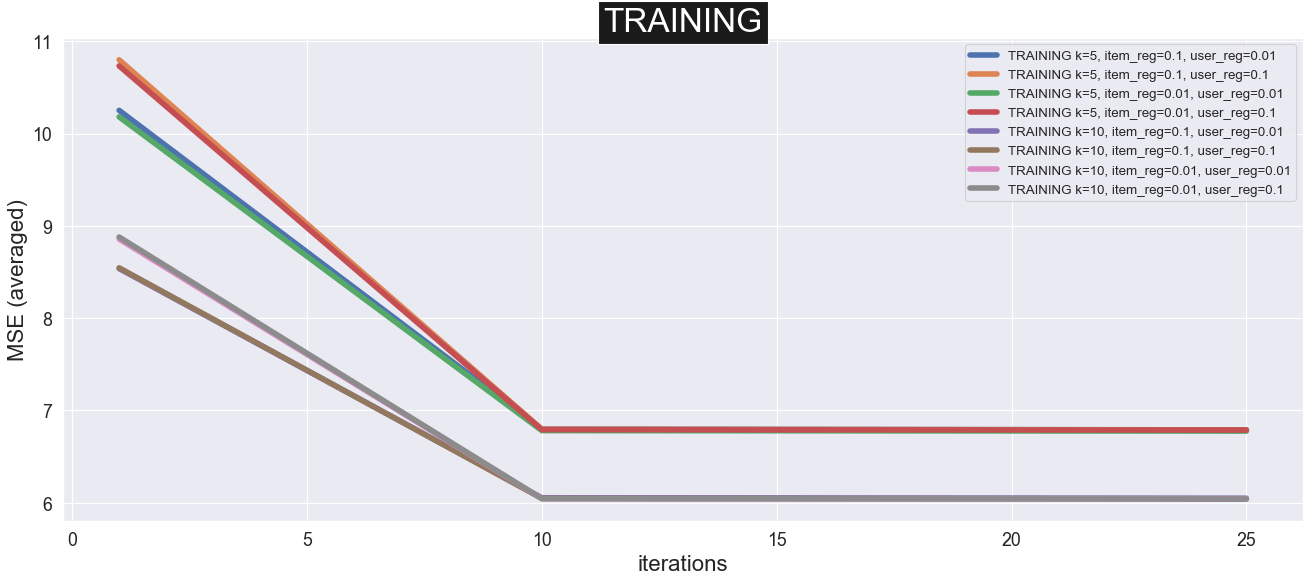

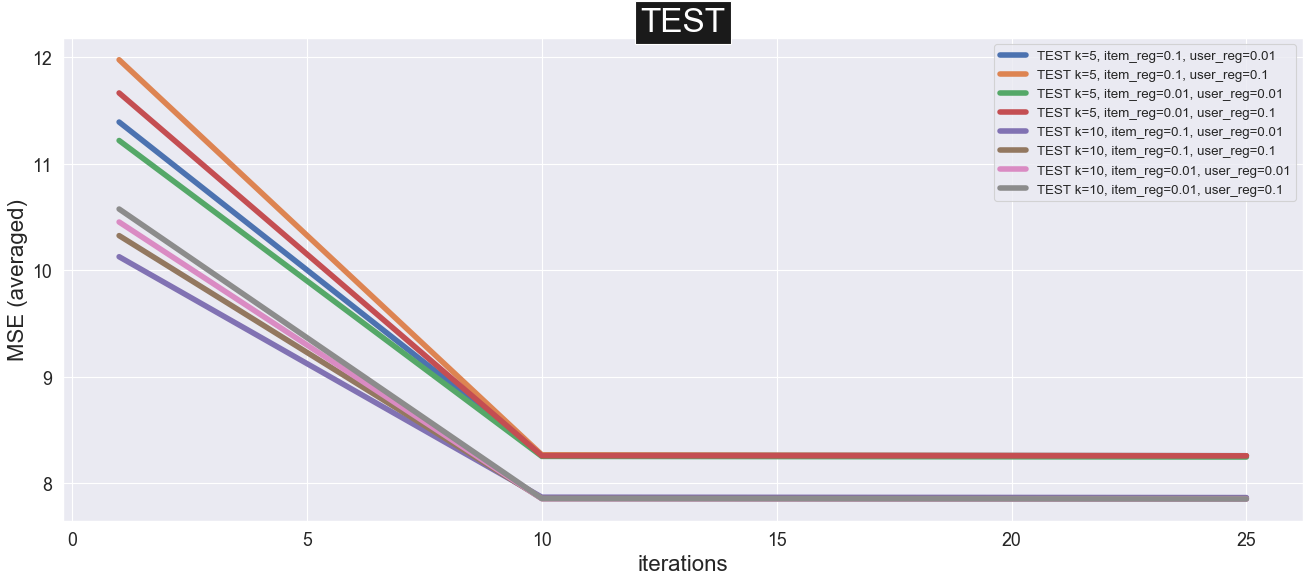

In [114]:
plot_learning_curve_list(iter_array, als_averages_result, title='TRAINING', mse_extractor=lambda model: model["training_mse"], model_type="als")
plot_learning_curve_list(iter_array, als_averages_result, title='TEST', mse_extractor=lambda model: model["test_mse"], model_type="als")

### Question 3: Matrix factorization – item similarity and model explainability (25 points)

#### Answer: